
# Assignment 4 - DSE 203 - JedAI

Group 5 - Zufeshan, Vaaruni, Christopher

In [ ]:
!pip install pyjedai -U

In [ ]:
!pip show pyjedai

Name: pyjedai
Version: 0.1.3
Summary: An open-source library that builds powerful end-to-end Entity Resolution workflows.
Home-page: 
Author: 
Author-email: Konstantinos Nikoletos <nikoletos.kon@gmail.com>, George Papadakis <gpapadis84@gmail.com>, Jakub Maciejewski <jacobb.maciejewski@gmail.com>, Manolis Koubarakis <koubarak@di.uoa.gr>
License: Apache Software License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: faiss-cpu, gensim, matplotlib, matplotlib-inline, networkx, nltk, numpy, optuna, ordered-set, pandas, pandas-profiling, pandocfilters, plotly, py-stringmatching, PyYAML, rdflib, rdfpandas, regex, scipy, seaborn, sentence-transformers, strsim, strsimpy, tomli, tqdm, transformers, valentine
Required-by: 


Imports

In [34]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph

from pyjedai.utils import print_clusters, print_blocks, print_candidate_pairs


## Reading the dataset

In [35]:
from pyjedai.datamodel import Data

d1 = pd.read_csv("/content/people.csv", sep=',')
d1['name'] = d1[' given_name'].str.strip()+' '+d1[' surname'].str.strip()
d1['address'] = d1[' street_number'].str.strip()+' '+d1[' address_1'].str.strip()+' '+d1[' address_2'].str.strip()

#gt = pd.read_csv("./../data/der/cora/cora_gt.csv", sep='|', header=None)
attr = ['name','address', ' suburb',' postcode',' state' ]


Data is the connecting module of all steps of the workflow

In [36]:
data = Data(
    dataset_1=d1,
    id_column_name_1='rec_id',
    #ground_truth=gt,
    attributes_1=attr
)

## Block Building


In [37]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
    ExtendedQGramsBlocking
)

In [38]:
bb = SuffixArraysBlocking(suffix_length=2)
blocks = bb.build_blocks(data)

Suffix Arrays Blocking:   0%|          | 0/5000 [00:00<?, ?it/s]

## Block Purging


In [39]:
from pyjedai.block_cleaning import BlockPurging

In [40]:
bp = BlockPurging()
cleaned_blocks = bp.process(blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/30772 [00:00<?, ?it/s]

In [41]:
bp.report()

Method name: Block Purging
Method info: Discards the blocks exceeding a certain number of comparisons.
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 1378.0
Runtime: 0.2140 seconds


## Block Cleaning


In [42]:
from pyjedai.block_cleaning import BlockFiltering

In [43]:
bc = BlockFiltering(ratio=0.9)
blocks = bc.process(blocks, data)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

## Comparison Cleaning -  Meta Blocking

In [44]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ComparisonPropagation
)

In [45]:
mb = WeightedEdgePruning(weighting_scheme='CBS')
blocks = mb.process(blocks, data)

Weighted Edge Pruning:   0%|          | 0/5000 [00:00<?, ?it/s]

## Entity Matching

It compares pairs of entity profiles, associating every pair with a similarity in [0,1]. Its output comprises the similarity graph, i.e., an undirected, weighted graph where the nodes correspond to entities and the edges connect pairs of compared entities.

In [46]:
from pyjedai.matching import EntityMatching

In [47]:
em = EntityMatching(
    metric='jaccard',
    similarity_threshold=0.0
)

pairs_graph = em.predict(blocks, data)

Entity Matching (jaccard, white_space_tokenizer):   0%|          | 0/4600 [00:00<?, ?it/s]

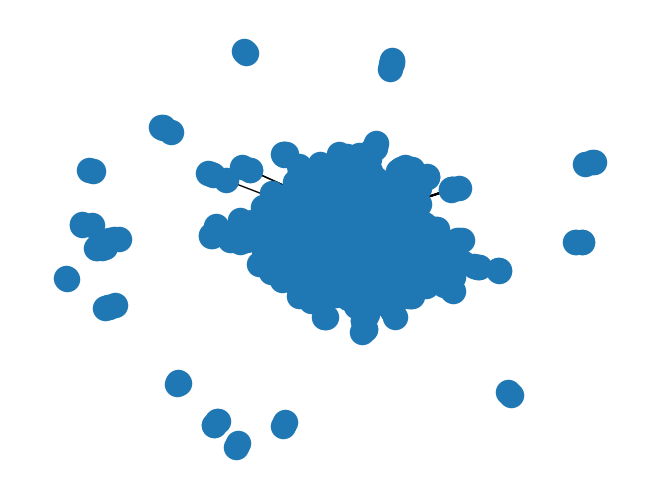

In [ ]:
draw(pairs_graph)

## Entity Clustering


In [48]:
from pyjedai.clustering import ConnectedComponentsClustering

In [53]:
ec = ConnectedComponentsClustering()
clusters = ec.process(pairs_graph, data, similarity_threshold=0.3)

In [54]:
df = ec.export_to_df(clusters)
df.to_csv('clusters.csv')
df.head()

,id1,id2
0,17,4029
1,17,1008
2,4029,1008
3,3497,3290
4,3497,3


In [55]:
import networkx as nx

clusters_df = pd.read_csv('clusters.csv')
people_df = pd.read_csv('people.csv')

G = networkx.Graph()
G.add_edges_from(clusters_df[['id1', 'id2']].values)
clusters = list(networkx.connected_components(G))

id_to_cluster = {}
for i, cluster in enumerate(clusters):
    for node in cluster:
        id_to_cluster[node] = i

people_df['cluster_id'] = people_df['rec_id'].map(id_to_cluster)

next_cluster_id = len(clusters)
people_df.loc[people_df['cluster_id'].isna(), 'cluster_id'] = range(next_cluster_id, next_cluster_id + people_df['cluster_id'].isna().sum())

people_df['cluster_id'] = people_df['cluster_id'].astype(int)
people_df = people_df.sort_values('cluster_id')

people_df.to_csv('jedai.csv', index=False)